Project FILIÈRE RECHERCHE

Under the supervision of :

Elisabeth Lahalle

Students :

- Ricardo Chiquetto do Lago
- Maxsuel Fernandes de Almeida
- Samara Ndiaye
- Ana Cecilia Reghini
- Lucas Tramonte

# Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import LocalOutlierFactor

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Data

In [2]:
data_gamma_irradiation = pd.read_csv("Assets/Data/2015_months_DebitDoseA.csv")
data_hygometry = pd.read_csv("Assets/Data/2015_months_HYGR.csv")
data_patm = pd.read_csv("Assets/Data//2015_months_PATM.csv")
data_temp = pd.read_csv("Assets//Data//2015_months_TEMP.csv")

In [3]:
data = data_gamma_irradiation.copy()
data

,24/02/2015 11:20,30/04/2015 13:10,22/06/2015 07:31,20/10/2015 09:18
0,92.8536,96.38690,96.98370,104.8191
1,91.8084,95.68260,96.33440,103.6979
2,93.3221,97.17039,96.67419,104.6446
3,91.7464,97.41650,97.40680,104.3136
4,93.4146,97.39280,97.60400,104.5342
...,...,...,...,...
40314,103.1037,97.12400,101.08090,97.3781
40315,102.4074,98.34760,100.19280,98.0843
40316,103.0529,98.91140,101.56070,99.6903
40317,102.9746,98.82339,101.22470,100.9240


# Data Visualization

In [4]:
data

,24/02/2015 11:20,30/04/2015 13:10,22/06/2015 07:31,20/10/2015 09:18
0,92.8536,96.38690,96.98370,104.8191
1,91.8084,95.68260,96.33440,103.6979
2,93.3221,97.17039,96.67419,104.6446
3,91.7464,97.41650,97.40680,104.3136
4,93.4146,97.39280,97.60400,104.5342
...,...,...,...,...
40314,103.1037,97.12400,101.08090,97.3781
40315,102.4074,98.34760,100.19280,98.0843
40316,103.0529,98.91140,101.56070,99.6903
40317,102.9746,98.82339,101.22470,100.9240


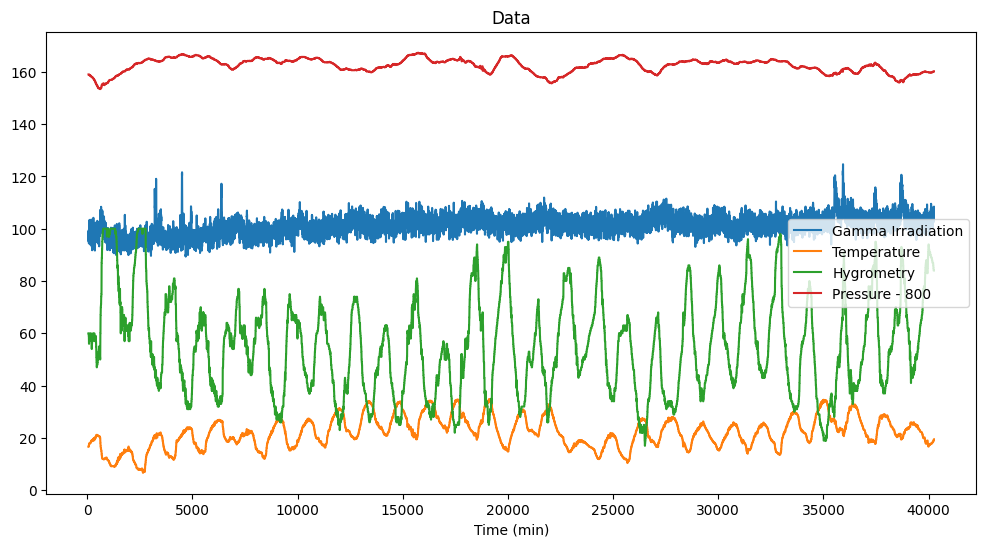

In [46]:
# Define the month (1: February, 2: April, 3: June, 4: October)
month = 3  # selected month: June

# Extract data for the selected month
sigg = data.iloc[:, month-1]  # Gamma irradiation data
sigt = data_temp.iloc[:, month-1]               # Temperature data
sigh = data_hygometry.iloc[:, month-1]          # Hygrometry data
sigp = data_patm.iloc[:, month-1]               # Atmospheric pressure data

# Remove the first and last hour of data
N = len(sigg)  # number of data points
fe = 1/60      # sampling frequency
t = list(range(N))  # time vector

Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_trimmed, sigg[Nh:N-Nh], label='Gamma Irradiation')
plt.plot(t_trimmed, sigt[Nh:N-Nh], label='Temperature')
plt.plot(t_trimmed, sigh[Nh:N-Nh], label='Hygrometry')
plt.plot(t_trimmed, sigp[Nh:N-Nh] - 800, label='Pressure - 800')

plt.xlabel('Time (min)')
plt.title('Data')
plt.legend()
plt.show()


# LSTMs

### IQR for outlier detection 

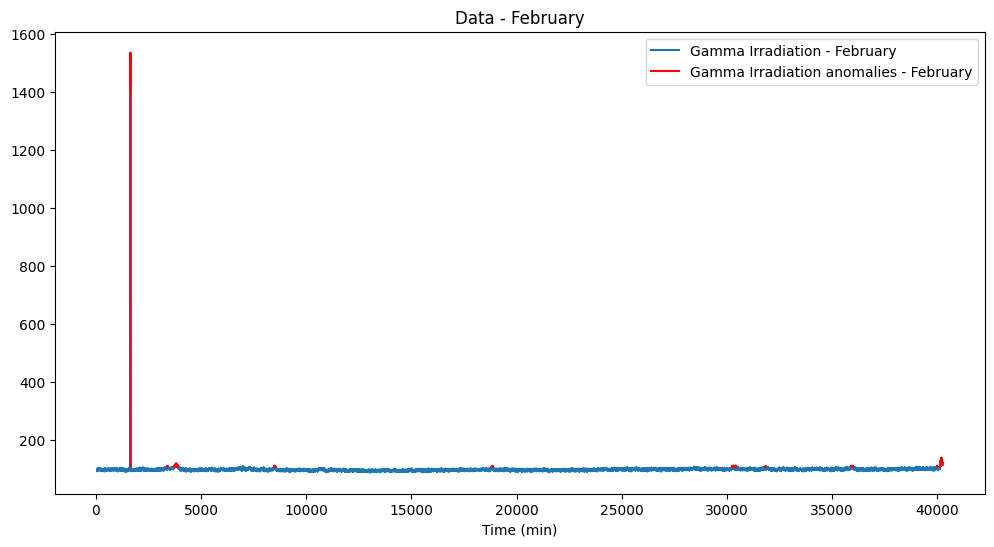

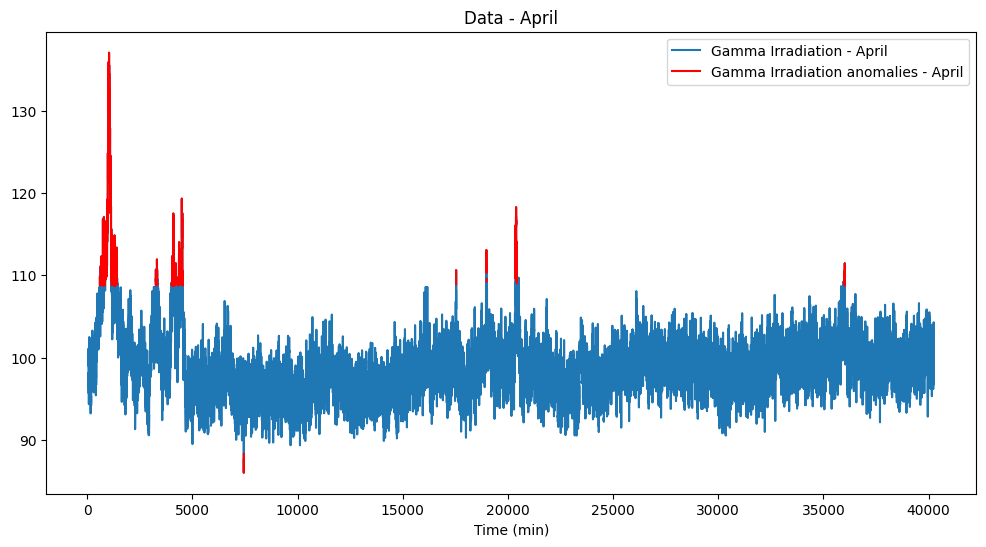

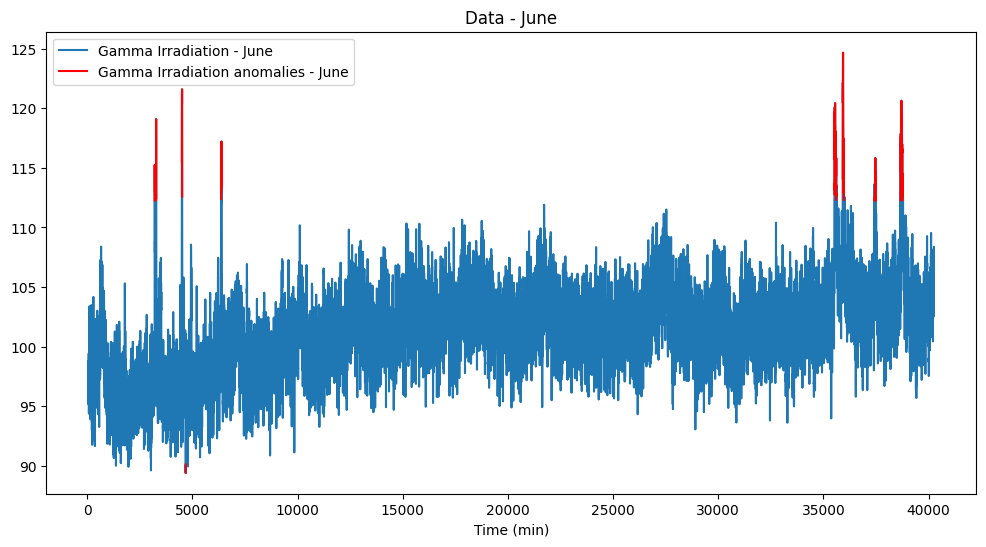

In [44]:
def IQR(X_train, month_col, month_name):
    """
    Function to process the data for a specific month, detect anomalies, and plot the results.
    
    Parameters:
    - X_train: DataFrame containing training data for all columns
    - month_col: index or name of the column representing the specific month to be processed
    - month_name: name of the month (for plot title)
    """
    # Extract data for the selected month
    sigg = X_train.iloc[:, month_col]

    # Remove the first and last hour of data
    N = len(sigg)  # number of data points
    Nh = 60  # 1 hour (60 minutes)
    t = list(range(N))  # time vector
    t_trimmed = t[Nh:N-Nh]  # trimming first and last hour

    ## Anomaly: IQR
    Q1 = sigg.quantile(0.25)
    Q3 = sigg.quantile(0.75)
    IQR = Q3 - Q1

    threshold_lower = Q1 - 2 * IQR
    threshold_upper = Q3 + 2 * IQR

    # Detect anomalies
    anomalies = X_train[(X_train < threshold_lower) | (X_train > threshold_upper)]
    sigg_anomaly = anomalies.iloc[:, month_col]

    # Remove the first and last hour of anomaly data
    N_a = len(sigg_anomaly)  # number of data points
    t_a = list(range(N_a))  # time vector for anomalies
    t_trimmed_a = t_a[Nh:N_a-Nh]

    plt.figure(figsize=(12, 6))
    plt.plot(t_trimmed, sigg[Nh:N-Nh], label=f'Gamma Irradiation - {month_name}')
    plt.plot(t_trimmed_a, sigg_anomaly[Nh:N_a-Nh], label=f'Gamma Irradiation anomalies - {month_name}', color='r')

    plt.xlabel('Time (min)')
    plt.title(f'Data - {month_name}')
    plt.legend()
    plt.show()

# Split the data into training and testing sets
X_train = data.iloc[:, 0:3]
X_test = data.iloc[:, -1]

IQR(X_train, 0, "February") 
IQR(X_train, 1, "April")    
IQR(X_train, 2, "June")     
